In [2]:
import festim as F
import fenics as f
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
import h_transport_materials as htm

Creating 2D mesh with FEniCS and marking its subdomains

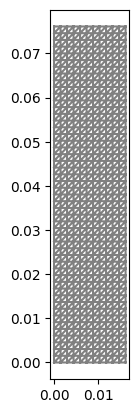

In [3]:
from fenics import Point, RectangleMesh, CompiledSubDomain, MeshFunction, plot

# creating a mesh with FEniCS
nx = round(50*(0.0162/0.0761))
ny = 50
# mesh_fenics = UnitSquareMesh(nx, ny)

mesh_fenics = RectangleMesh(Point(0.0, 0.0), Point(0.0162, 0.0761), nx, ny)

# marking physical groups (volumes and surfaces)
volume_markers = MeshFunction(
    "size_t", mesh_fenics, mesh_fenics.topology().dim())
volume_markers.set_all(1)

left_surface = CompiledSubDomain(
    'on_boundary && near(x[0], 0, tol)', tol=1e-14)
right_surface = CompiledSubDomain(
    'on_boundary && near(x[0], 0.0162, tol)', tol=1e-14)
bottom_surface = CompiledSubDomain(
    'on_boundary && near(x[1], 0, tol)', tol=1e-14)
top_surface = CompiledSubDomain(
    'on_boundary && near(x[1], 0.0761, tol)', tol=1e-14)

surface_markers = MeshFunction(
    "size_t", mesh_fenics, mesh_fenics.topology().dim() - 1)
surface_markers.set_all(0)

# Surface ids
left_id = 1
top_id = 2
right_id = 3
bottom_id = 4
left_surface.mark(surface_markers, left_id)
right_surface.mark(surface_markers, right_id)
top_surface.mark(surface_markers, top_id)
bottom_surface.mark(surface_markers, bottom_id)

plot(mesh_fenics)

Functions defining flibe properties:

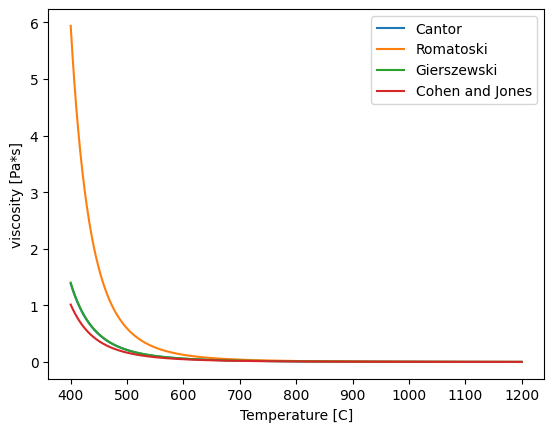

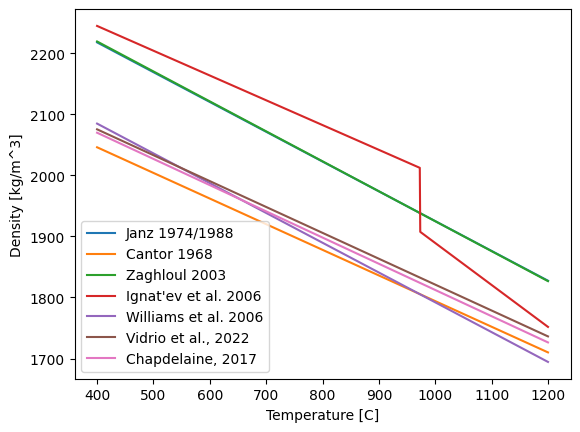

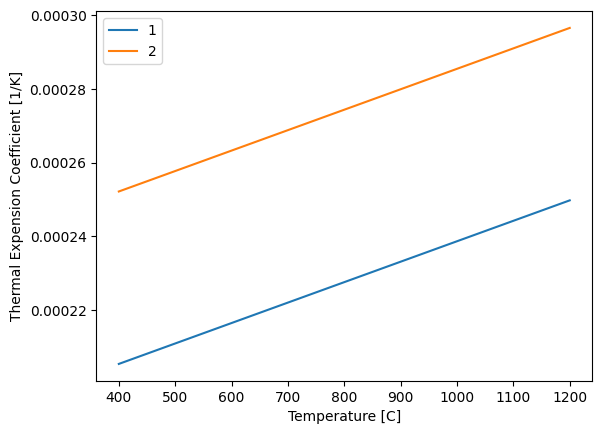

In [15]:
# desnisties taken from fluoride salt coolant properties paper
def density_flibe1(T): # Janz 1974/1988 (3,14,17,21,22)
    return 2413 - 0.488 * T  # kg/m3

def density_flibe2(T): # Cantor 1968 (18,19)
    return 2214 - 0.42 * T

def density_flibe3(T): # Zaghloul 2003 (7,14,22)
    return 2415.6 - 0.49072 * T

def density_flibe4(T): # Ignat'ev et al. 2006
    if T < 973:
        return 2163 - 0.406*(T-601.4)
    else:
        return 2163 - 0.687*(T-601.4)

def density_flibe5(T): # Williams et al. 2006
    return 2280 - 0.488 * T

def density_flibe6(T): # Vidrio et al., 2022
    return 2245 - 0.424 * T

def density_flibe7(T): # Chapdelaine, 2017
    return 2241.6 - 0.42938 * T

density_prop_array = [(density_flibe1, "Janz 1974/1988"),
                      (density_flibe2, "Cantor 1968"),
                      (density_flibe3, "Zaghloul 2003"),
                      (density_flibe4, "Ignat'ev et al. 2006"),
                      (density_flibe5, "Williams et al. 2006"),
                      (density_flibe6, "Vidrio et al., 2022"),
                      (density_flibe7, "Chapdelaine, 2017")]


# viscosities taken from fluoride salt coolant properties paper
e = 2.718281828459045
def viscosity_flibe1(T): # Cantor (3–7,11,14,18)
    return 1.16e-04 * e ** (3755 / (T + DOLFIN_EPS))  # Pa.s

def viscosity_flibe2(T): # Romatoski (12,17,21,32)
    return 5.94e-05 * e ** (4605 / (T + DOLFIN_EPS))  # Pa.s

def viscosity_flibe3(T): # Gierszewski (20)
    return 1.16e-04 * e ** (3760 / (T + DOLFIN_EPS))  # Pa.s

def viscosity_flibe4(T): # Cohen and Jones (30,31,33)
    return 1.18e-04 * e ** (3624 / (T + DOLFIN_EPS))  # Pa.s

viscosity_prop_array = [(viscosity_flibe1, "Cantor"),
                        (viscosity_flibe2, "Romatoski"),
                        (viscosity_flibe3, "Gierszewski"),
                        (viscosity_flibe4, "Cohen and Jones")]


def beta_flibe1(T):
    return 1.8319e-04 + 5.55e-08 * T  # K-1

def beta_flibe2(T):
    return 2.3e-04 + 5.55e-08 * T  # K-1

# T_array = np.linspace(700, 1200, 10)
# B_array = beta_flibe1(T_array)
# B_array2 = beta_flibe2(T_array)

# plt.plot(T_array, B_array)
# plt.plot(T_array, B_array2)
# plt.yscale("log")
# plt.show()

beta_prop_array = [(beta_flibe1, '1'),
                   (beta_flibe2, '2')]


def plot_properties():
    T = np.linspace(400, 1200, 1000)

    plt.figure()
    for viscosity_func, name in viscosity_prop_array:
        mu = viscosity_func(T)
        plt.plot(T, mu, label=name)
    plt.legend()
    plt.xlabel("Temperature [C]")
    plt.ylabel("viscosity [Pa*s]")

    plt.figure()
    for density_func, name in density_prop_array:
        rho = []
        for t in T:
            rho.append(density_func(t))
        plt.plot(T, rho, label=name)
    plt.legend()
    plt.xlabel("Temperature [C]")
    plt.ylabel("Density [kg/m^3]")

    plt.figure()
    for beta_func, name in beta_prop_array:
        beta = []
        for t in T:
            beta.append(beta_func(t))
        plt.plot(T, beta, label=name)
    plt.legend()
    plt.xlabel("Temperature [C]")
    plt.ylabel("Thermal Expension Coefficient [1/K]")

    plt.show()

plot_properties()


CFD simulation function:

In [171]:

def velocity_field(T_cold, T_hot, my_mesh, density_flibe=density_flibe1, viscosity_flibe=viscosity_flibe1, beta_flibe=beta_flibe1):
    """Computes the velocity field for a given mesh and temperature difference

    Args:
        T_cold (float): the cold temperature (right) in K
        T_hot (float): the hot temperature (left) in K
        my_mesh (fenics.Mesh): the mesh

    Returns:
        fenics.Function, fenics.Function, fenics.Function: veocity field (m/s), pressure (Pa), temperature (K)
    """
    T_bulk = ((T_hot - T_cold) / 2) + T_cold

    V_ele = VectorElement("CG", my_mesh.ufl_cell(), 2)
    Q_ele = FiniteElement("CG", my_mesh.ufl_cell(), 1)
    T_ele = FiniteElement("CG", my_mesh.ufl_cell(), 1)
    W = FunctionSpace(my_mesh, MixedElement([V_ele, Q_ele, T_ele]))

    upT = Function(W)
    upT_old = Function(W)
    u, p, T = split(upT)
    v, q, S = TestFunctions(W)

    for factor in [1e-03, 1e-02, 1e-01, 3e-01, 1]:
        print("Running for factor={:.1e}".format(factor))

        g = Constant((0, -9.81))  # gravity acceleration in m/s2
        mu = viscosity_flibe(T_bulk)  # dynamic viscosity in kg/m/s
        rho = density_flibe(T_bulk)  # density in kg/m3
        rho_0 = density_flibe(T_cold)  # density at T_cold
        cp = 2386  # heat capacity in J/(kg.K)
        thermal_cond = 1.1  # thermal conductivity in W/(m.K)
        beta = beta_flibe(T_bulk) * factor

        # CFD momentum
        F = (
            rho_0 * inner(dot(grad(u), u), v) * dx
            - inner(p, div(v)) * dx
            + mu * inner(grad(u), grad(v)) * dx
            + inner(rho_0 * beta * (T - T_bulk) * g, v) * dx
        )

        # CFD continuity
        F -= inner(q, div(u)) * dx

        # Heat transfer
        F += rho * cp * inner(dot(grad(T), u), S) * dx
        F += inner(thermal_cond * grad(T), grad(S)) * dx

        bcs = [
            DirichletBC(W.sub(0), Constant((0, 0)), "on_boundary"),
            DirichletBC(W.sub(2), T_hot, "on_boundary && x[0] == 0"),
            DirichletBC(W.sub(2), T_cold, "on_boundary && x[0] == 0.0162"),  # TODO make this more generic
        ]

        solve(
            F == 0,
            upT,
            bcs=bcs,
            solver_parameters={
                "newton_solver": {
                    "linear_solver": "mumps",
                    "absolute_tolerance": 1e-09,
                    "relative_tolerance": 1e-09,
                    "maximum_iterations": 25,
                }
            },
        )

        upT_old.assign(upT)

    u, p, T = upT.split()

    return u, p, T


Diffusion Simulation:

In [172]:
def my_simulation(temperature_field, mesh_fenics, velocity):
    """
    Takes in a list of temperatures and a set mesh and returns a list of diffusion coefficients that correspond to each temperature

    Args:
        temperature_field (fenics.Function): the temperature field in K
        mesh_fenics (fenics.Mesh): the mesh (should be the same as the one used to compute the temperature field)
        velocity (fenics.Function): the velocity field in m/s

    Returns:
        float: the mass transport coefficient in m/s
    """
    # setting up current simulation
    model_2d = F.Simulation()

    # D, E_d source: "nakamura_hydrogen_2015"
    # Thermal cond source: https://dspace.mit.edu/bitstream/handle/1721.1/123988/Romatoski_SaltPropertyReview02.pdf?sequence=1&isAllowed=y#:~:text=From%20the%20data%20collected%2C%20the,an%20uncertainty%20of%20%C2%B110%25.
    flibe_mat = F.Material(
        id=1,
        D_0=1.508521565198744e-08,
        E_D=0.23690444592353738,
        thermal_cond=1.1  #  <--- not needed here
        )
    model_2d.materials = F.Materials([flibe_mat])

    # creating mesh with festim
    model_2d.mesh = F.Mesh(
        mesh=mesh_fenics,  # TODO we should be able to get the mesh from the temperature field
        volume_markers=volume_markers,
        surface_markers=surface_markers
    )

    # setting up steady state heat transfer problem

    # model_2d.T = F.TemperatureFromXDMF(temperature_file, label="temperature")
    model_2d.T = F.Temperature(value=973)  # dummy temperature, will be overwritten later


    # setting up T source
    model_2d.sources = [
        F.Source(
            value=1.84*10**5/(0.0761*0.0162), 
            volume=1, 
            field=0
            )
        ]

    
    # setting up transport boundary conditions
    tritium_transport_bcs = [
        F.DirichletBC(
            surfaces=[top_id, bottom_id, right_id], 
            value=0, 
            field=0
            )
    ]

    model_2d.boundary_conditions = tritium_transport_bcs

    
    # simulation parameters and running model
    model_2d.settings = F.Settings(
        transient=False,
        absolute_tolerance=1e-09,
        relative_tolerance=1e-09,
    )

    # setting up exports
    export_folder = "BABY_2D_results"

    derived_quantities = F.DerivedQuantities(filename=export_folder + "/simulation.csv")

    derived_quantities.derived_quantities = [
        F.SurfaceFlux(field="solute", surface=left_id),
        F.SurfaceFlux(field="solute", surface=right_id),
        F.SurfaceFlux(field="solute", surface=top_id),
        F.SurfaceFlux(field="solute", surface=bottom_id),
        F.AverageVolume(field="solute", volume=1)
        ]

    model_2d.exports = F.Exports([
        F.XDMFExport("solute", folder=export_folder),
        F.XDMFExport("retention", folder=export_folder),
        F.XDMFExport("T", folder=export_folder),
        derived_quantities
        ])
    # adding advection
    model_2d.initialise() # reinitialisation is needed

    model_2d.T.T = temperature_field
    model_2d.T.T_n = temperature_field  # don't know if this is needed

    hydrogen_concentration = model_2d.h_transport_problem.mobile.solution
    test_function_solute = model_2d.h_transport_problem.mobile.test_function

    advection_term = inner(dot(grad(hydrogen_concentration), velocity), test_function_solute) * model_2d.mesh.dx

    model_2d.h_transport_problem.F += advection_term

    model_2d.run()

    plt.figure()
    plt.title("Hydrogen concentration")
    CS = plot(hydrogen_concentration)
    plot(velocity, scale=1e-3, color="black", alpha=0.5)
    plt.colorbar(CS, label="H/m3")
    plt.show()
    

    # reading results
    my_data = np.genfromtxt(export_folder + "/simulation.csv", names=True, delimiter=",")

    flux_1 = my_data["Flux_surface_1_solute"]
    flux_2 = my_data["Flux_surface_2_solute"]
    flux_3 = my_data["Flux_surface_3_solute"]
    flux_4 = my_data["Flux_surface_4_solute"]

    # calculating diffusion coefficient
    total_flux = abs(flux_1 + flux_2 + flux_3 + flux_4)

    average_conc = my_data["Average_solute_volume_1"]

    A = 0.0761*0.0162  # m2
    k = total_flux/(A*average_conc)

    print(f"Total flux: {total_flux} H/s/m")
    print(f"Average concentration: {average_conc} H/m3")
    print(f"k: {k} /s  (double check the units)")

    return k

----------  Running for dT=0 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=3.0e-01
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/materials/materials.py:122: UserWarning: thermal_cond key will be ignored
  warnings.warn("thermal_cond key will be ignored", UserWarning)


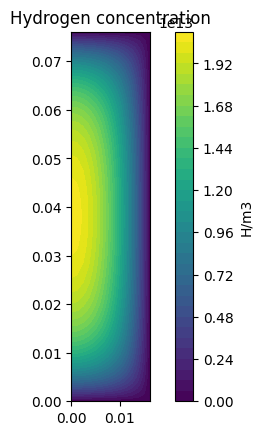

Total flux: 169132.97213061515 H/s/m
Average concentration: 10660472014147.44 H/m3
k: 1.2869218510937905e-05 /s  (double check the units)
----------  Running for dT=0.1 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=3.0e-01
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/materials/materials.py:122: UserWarning: thermal_cond key will be ignored
  warnings.warn("thermal_cond key will be ignored", UserWarning)


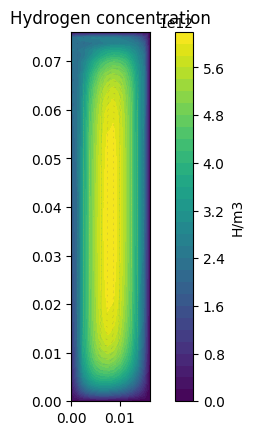

Total flux: 178506.88806182425 H/s/m
Average concentration: 3862103728671.0576 H/m3
k: 3.749137544872698e-05 /s  (double check the units)
----------  Running for dT=0.25 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=3.0e-01
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/materials/materials.py:122: UserWarning: thermal_cond key will be ignored
  warnings.warn("thermal_cond key will be ignored", UserWarning)


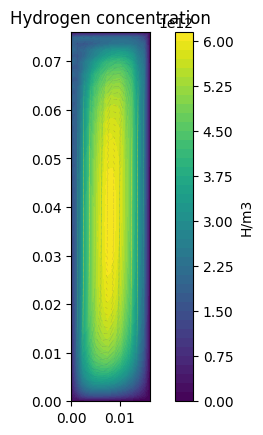

Total flux: 180467.82787912604 H/s/m
Average concentration: 3664982172742.4385 H/m3
k: 3.994185708309729e-05 /s  (double check the units)
----------  Running for dT=0.5 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=3.0e-01
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/materials/materials.py:122: UserWarning: thermal_cond key will be ignored
  warnings.warn("thermal_cond key will be ignored", UserWarning)


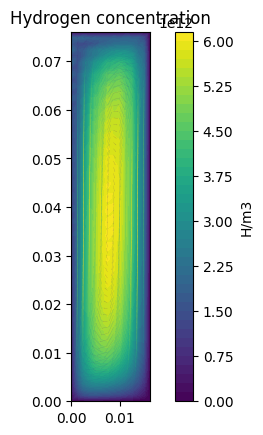

Total flux: 181629.7378424382 H/s/m
Average concentration: 3545306471758.8066 H/m3
k: 4.155597739289042e-05 /s  (double check the units)
----------  Running for dT=1 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=3.0e-01
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/materials/materials.py:122: UserWarning: thermal_cond key will be ignored
  warnings.warn("thermal_cond key will be ignored", UserWarning)


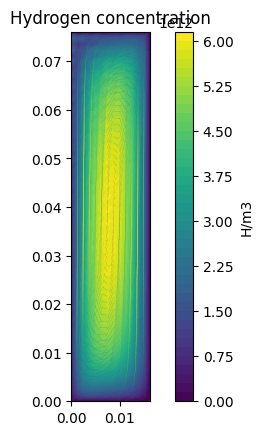

Total flux: 182586.44159043577 H/s/m
Average concentration: 3455943082631.223 H/m3
k: 4.2855076251973515e-05 /s  (double check the units)
----------  Running for dT=3 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=3.0e-01
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/materials/materials.py:122: UserWarning: thermal_cond key will be ignored
  warnings.warn("thermal_cond key will be ignored", UserWarning)


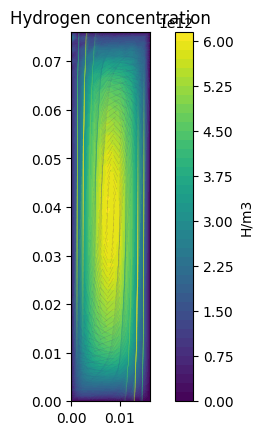

Total flux: 186585.36217955247 H/s/m
Average concentration: 3351131369699.435 H/m3
k: 4.516338088993917e-05 /s  (double check the units)
----------  Running for dT=10 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=3.0e-01
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/materials/materials.py:122: UserWarning: thermal_cond key will be ignored
  warnings.warn("thermal_cond key will be ignored", UserWarning)


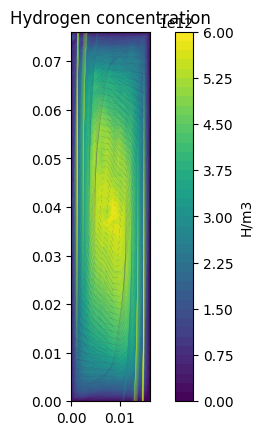

Total flux: 204069.35128484174 H/s/m
Average concentration: 3200380344760.674 H/m3
k: 5.172214388201189e-05 /s  (double check the units)
----------  Running for dT=0 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=3.0e-01
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/materials/materials.py:122: UserWarning: thermal_cond key will be ignored
  warnings.warn("thermal_cond key will be ignored", UserWarning)


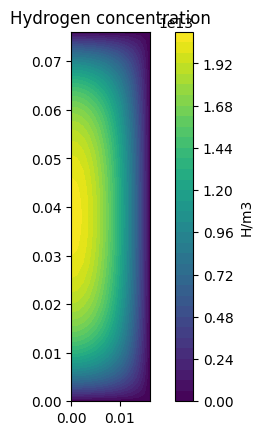

Total flux: 169132.97213060773 H/s/m
Average concentration: 10660472014146.31 H/m3
k: 1.2869218510938703e-05 /s  (double check the units)
----------  Running for dT=0.1 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=3.0e-01
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/materials/materials.py:122: UserWarning: thermal_cond key will be ignored
  warnings.warn("thermal_cond key will be ignored", UserWarning)


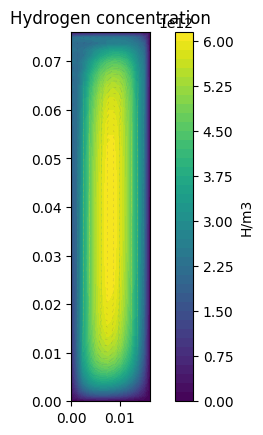

Total flux: 178889.38075394338 H/s/m
Average concentration: 3818971010783.603 H/m3
k: 3.79960567514603e-05 /s  (double check the units)
----------  Running for dT=0.25 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=3.0e-01
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/materials/materials.py:122: UserWarning: thermal_cond key will be ignored
  warnings.warn("thermal_cond key will be ignored", UserWarning)


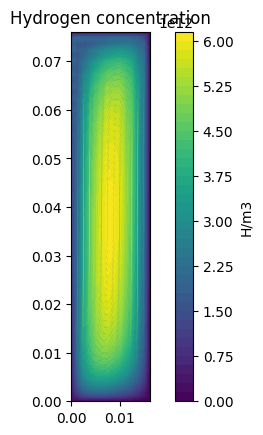

Total flux: 180815.3565395269 H/s/m
Average concentration: 3631530825960.7695 H/m3
k: 4.0387400936389555e-05 /s  (double check the units)
----------  Running for dT=0.5 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=3.0e-01
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/materials/materials.py:122: UserWarning: thermal_cond key will be ignored
  warnings.warn("thermal_cond key will be ignored", UserWarning)


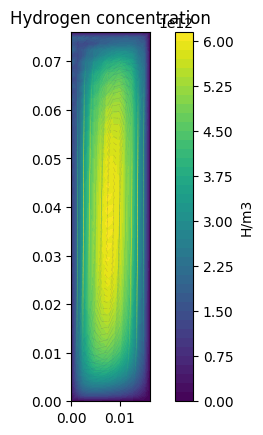

Total flux: 181868.560482431 H/s/m
Average concentration: 3518714761615.0024 H/m3
k: 4.1925079522955985e-05 /s  (double check the units)
----------  Running for dT=1 K  ----------
Running for factor=1.0e-03
Running for factor=1.0e-02
Running for factor=1.0e-01
Running for factor=3.0e-01
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Running for factor=1.0e+00
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/materials/materials.py:122: UserWarning: thermal_cond key will be ignored
  warnings.warn("thermal_cond key will be ignored", UserWarning)


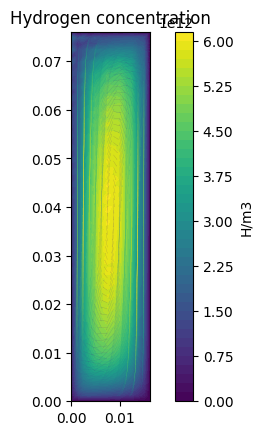

Total flux: 182919.01837270174 H/s/m
Average concentration: 3437260375225.8677 H/m3
k: 4.316649228287373e-05 /s  (double check the units)
----------  Running for dT=3 K  ----------
Running for factor=1.0e-03
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Running for factor=1.0e-02
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Running for factor=1.0e-01
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Running for factor=3.0e-01
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Running for factor=1.0e+00
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/materials/materials.py:122: UserWarning: thermal_cond key will be ignored
  warnings.warn("thermal_cond key will be ignored", UserWarning)


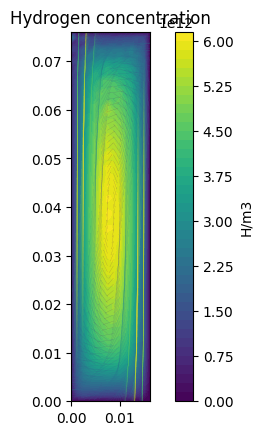

Total flux: 187757.49611358313 H/s/m
Average concentration: 3333530052775.7144 H/m3
k: 4.568706285649918e-05 /s  (double check the units)
----------  Running for dT=10 K  ----------
Running for factor=1.0e-03
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Running for factor=1.0e-02
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Running for factor=1.0e-01
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Running for factor=3.0e-01
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Running for factor=1.0e+00
Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Calling FFC just-in-time (JIT) compiler, this may take some time.


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1458: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  initializer_lists = build_initializer_lists(self.values, self.sizes, 0,
/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/ffc/uflacs/language/cnodes.py:1359: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [build_1d_initializer_list(values, formatter, padlen=padlen, precision=precision)]
/Users/colinweaver/anaconda3/envs/festim-env/lib/python

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


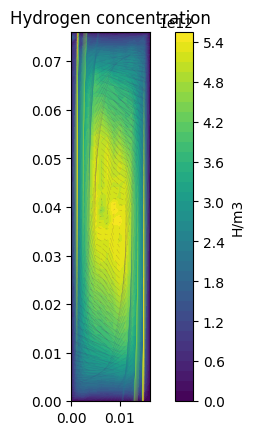

Total flux: 209322.24680765043 H/s/m
Average concentration: 3167642155299.147 H/m3
k: 5.3601828195546306e-05 /s  (double check the units)


In [173]:
if __name__ == "__main__":
    T_hot = 700 + 273.15

    # prop_array = [(density_flibe1, "Janz 1974/1988"), (density_flibe2, "Cantor 1968"), (density_flibe3, "Zaghloul 2003")]
    # prop_array = [(viscosity_flibe1, "(3-7,11,14,18)"), (viscosity_flibe2, "(12,17,21,32)"), (viscosity_flibe3, "(29)"), (viscosity_flibe4, "(20)"), (viscosity_flibe5, "(30,31,33)")]
    # prop_array = [(beta_flibe1, "1"), (beta_flibe2, "2")]

    dt_array = [0, 0.1, 0.25, 0.5, 1, 3, 10]

    # plt.figure()
    k_array_array = []
    for prop, name in beta_prop_array:

        k_array = []
        for dT in dt_array:
            print(f"----------  Running for dT={dT} K  ----------")
            foldername = f"Results/viscosity_{name}/dt={dT}/"
            T_cold = T_hot - dT
            u, p, T = velocity_field(T_cold=T_cold, T_hot=T_hot, my_mesh=mesh_fenics, beta_flibe=prop)

            XDMFFile(foldername + "temperature_field.xdmf").write_checkpoint(T, "temperature", 1, XDMFFile.Encoding.HDF5)
            XDMFFile(foldername + "velocity_field.xdmf").write(u)

            # plt.figure()
            # plt.title("Velocity field")
            # CS = plot(u, scale=1e-3)
            # plt.colorbar(CS, label="m/s")
            # plt.show()

            # plt.figure()
            # TS = plot(T, cmap="inferno")
            # plt.colorbar(TS, label="K")

            k = my_simulation(T, mesh_fenics, u)
            k_array.append(k)

        k_array_array.append(k_array)
        # plt.plot(dt_array, k_array, '-x', label=name, linewidth=3)

    # plt.figure()
    # for i in range(len(k_array_array)):
    #     plt.plot(dt_array, k_array_array[i], '-x', label=density_prop_array[i][1], linewidth=3)
    # plt.xlabel("Temperature difference [K]")
    # plt.ylabel("Transport Coefficient [m/s]")
    # plt.legend(loc = "upper right")
    # plt.show()

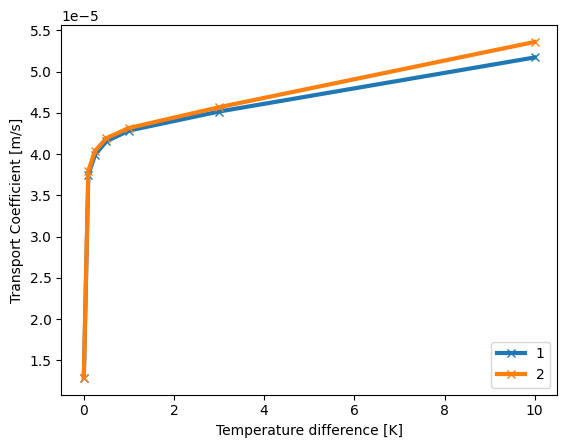

<Figure size 640x480 with 0 Axes>

In [174]:
plt.figure()
for i in range(len(k_array_array)):
    plt.plot(dt_array, k_array_array[i], '-x', label=beta_prop_array[i][1], linewidth=3)
plt.xlabel("Temperature difference [K]")
plt.ylabel("Transport Coefficient [m/s]")
plt.legend(loc = "lower right")
plt.show()
plt.savefig("betasComparison.svg")